# Experiment 1

Extracting the score of the match from a single frame

## Imports

In [1]:
# %env HSA_OVERRIDE_GFX_VERSION=10.3.0

import cv2
import numpy as np
from util import vid_to_frames
import torch
from PIL import Image

%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Using the GPU 😎')
else:
    device = torch.device('cpu')
    print('Using the CPU ‼️')

# device = torch.device('cpu')

Using the CPU ‼️


In [ ]:
test_vid = './test/test_vid.mp4'

PATCH_HEIGHT = 14
PATCH_WIDTH = 19

PATCH_TOP = 310
PATCH_BOTTOM = PATCH_TOP + PATCH_HEIGHT
L_PATCH_LEFT = 268
L_PATCH_RIGHT = L_PATCH_LEFT + PATCH_WIDTH
L_PATCH_MID = (L_PATCH_LEFT + L_PATCH_RIGHT) // 2 - 2
R_PATCH_LEFT = 357
R_PATCH_RIGHT = R_PATCH_LEFT + PATCH_WIDTH
R_PATCH_MID = (R_PATCH_LEFT + R_PATCH_RIGHT) // 2 - 2
ADJ = -32

cap = cv2.VideoCapture(test_vid)
cap.set(cv2.CAP_PROP_POS_FRAMES, 16_000)
flags, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

lwhole_patch = frame[PATCH_TOP:PATCH_BOTTOM, L_PATCH_LEFT:L_PATCH_RIGHT]
_, lwhole_patch = cv2.threshold(lwhole_patch, 255 + ADJ, 255, cv2.THRESH_BINARY)

lhalf_patch1 = lwhole_patch.copy()
lhalf_patch1[:, (L_PATCH_MID-L_PATCH_LEFT):] = 0

lhalf_patch2 = lwhole_patch.copy()
lhalf_patch2[:, :(L_PATCH_MID-L_PATCH_LEFT)] = 0
_, lhalf_patch2 = cv2.threshold(lhalf_patch2, 255 + ADJ, 255, cv2.THRESH_BINARY)
hpad = np.zeros((lhalf_patch2.shape[0], 28 - lhalf_patch2.shape[1]))
lhalf_patch2 = np.hstack((lhalf_patch2, hpad))

cv2.imshow('whole',lwhole_patch)
cv2.imshow('half1',lhalf_patch1)
cv2.imshow('half2',lhalf_patch2)
cv2.waitKey()
cv2.destroyAllWindows()

if np.any(lwhole_patch[:, 0] > 100):
    print("L's score is 2 digits")
else:
    print("L's score is 1 digit")

rwhole_patch = frame[PATCH_TOP:PATCH_BOTTOM, R_PATCH_LEFT:R_PATCH_RIGHT]
_, rwhole_patch = cv2.threshold(rwhole_patch, 255 + ADJ, 255, cv2.THRESH_BINARY)

rhalf_patch1 = rwhole_patch.copy()
rhalf_patch1[:, (R_PATCH_MID-R_PATCH_LEFT):] = 0

rhalf_patch2 = rwhole_patch.copy()
rhalf_patch2[:, :(R_PATCH_MID-R_PATCH_LEFT)] = 0
_, rhalf_patch2 = cv2.threshold(rhalf_patch2, 255 + ADJ, 255, cv2.THRESH_BINARY)

cv2.imshow('whole',rwhole_patch)
cv2.imshow('half1',rhalf_patch1)
cv2.imshow('half2',rhalf_patch2)
cv2.waitKey()
cv2.destroyAllWindows()

: 

bounding boxes (tlx, tly, brx, bry):

height: 310-330
width: 265-290, 355-375

lscore: (265, 310, 290, 330)
rscore: (355, 310, 370, 330)

In [53]:
from transformers import AutoImageProcessor, SiglipForImageClassification

model_name = "prithivMLmods/Mnist-Digits-SigLIP2"
mnist_model = SiglipForImageClassification.from_pretrained(model_name)
input_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

PATCH_HEIGHT = 14
PATCH_WIDTH = 19

PATCH_TOP = 310
PATCH_BOTTOM = PATCH_TOP + PATCH_HEIGHT
L_PATCH_LEFT = 268
L_PATCH_RIGHT = L_PATCH_LEFT + PATCH_WIDTH
L_PATCH_MID = (L_PATCH_LEFT + L_PATCH_RIGHT) // 2 - 2
R_PATCH_LEFT = 358
R_PATCH_RIGHT = R_PATCH_LEFT + PATCH_WIDTH
R_PATCH_MID = (R_PATCH_LEFT + R_PATCH_RIGHT) // 2 - 2
ADJ = -32

def predict_score_from_frame(frame, view_patches=False):
    blurred = frame
    # blurred = cv2.blur(frame, (2, 2))

    def vert_pad(patch):
        vpad = np.zeros((28 - patch.shape[0], patch.shape[1]))
        return np.vstack((patch, vpad))

    def horiz_pad(patch):
        hpad = np.zeros((patch.shape[0], 28 - patch.shape[1]))
        return np.hstack((patch, hpad))

    # the whole patch of FotL's score
    # this will be most accurate if score is 1 digit
    lwhole_patch = blurred[PATCH_TOP:PATCH_BOTTOM, L_PATCH_LEFT:L_PATCH_RIGHT]
    _, lwhole_patch = cv2.threshold(lwhole_patch, 255 + ADJ, 255, cv2.THRESH_BINARY)
    l_double = np.any(lwhole_patch[:, 0] > 100) # if any pixels on the left border are lit, it's double digits (1X where 0 <= X <= 5)
    lwhole_patch = horiz_pad(lwhole_patch)
    # lwhole_patch = vert_pad(lwhole_patch)

    # the masked RHS half-patch of FotL's score
    lhalf_patch2 = lwhole_patch.copy()
    lhalf_patch2[:, :(L_PATCH_MID-L_PATCH_LEFT)] = 0
    _, lhalf_patch2 = cv2.threshold(lhalf_patch2, 255 + ADJ, 255, cv2.THRESH_BINARY)
    lhalf_patch2 = horiz_pad(lhalf_patch2)
    # lhalf_patch2 = vert_pad(lhalf_patch2)

    if view_patches:
        cv2.imshow('left patch whole', lwhole_patch)
        cv2.imshow('left patch half2', lhalf_patch2)
        cv2.waitKey()
        cv2.destroyAllWindows()

    # the whole patch of FotR's score
    rwhole_patch = blurred[PATCH_TOP:PATCH_BOTTOM, R_PATCH_LEFT:R_PATCH_RIGHT]
    _, rwhole_patch = cv2.threshold(rwhole_patch, 255 + ADJ, 255, cv2.THRESH_BINARY)
    r_double = np.any(rwhole_patch[:, 0] > 100) # if any pixels on the left border are lit, it's double digits (1X where 0 <= X <= 5)
    rwhole_patch = horiz_pad(rwhole_patch)
    # rwhole_patch = vert_pad(rwhole_patch)

    # the masked RHS half-patch of FotR's score
    rhalf_patch2 = rwhole_patch.copy()
    rhalf_patch2[:, :(L_PATCH_MID-L_PATCH_LEFT)] = 0
    _, rhalf_patch2 = cv2.threshold(rhalf_patch2, 255 + ADJ, 255, cv2.THRESH_BINARY)
    rhalf_patch2 = horiz_pad(rhalf_patch2)
    # rhalf_patch2 = vert_pad(rhalf_patch2)

    if view_patches:
        cv2.imshow('right patch whole', rwhole_patch)
        cv2.imshow('left patch half2', rhalf_patch2)
        cv2.waitKey()
        cv2.destroyAllWindows()

    lwhole_input = input_processor(images=Image.fromarray(lwhole_patch), return_tensors='pt')
    lhalf2_input = input_processor(images=Image.fromarray(lhalf_patch2), return_tensors='pt')

    rwhole_input = input_processor(images=Image.fromarray(rwhole_patch), return_tensors='pt')
    rhalf2_input = input_processor(images=Image.fromarray(rhalf_patch2), return_tensors='pt')

    with torch.no_grad():
        lwhole_outputs = mnist_model(**lwhole_input)
        lwhole_logits = lwhole_outputs.logits
        lwhole_probs = torch.nn.functional.softmax(lwhole_logits, dim=1).squeeze()

        lhalf2_outputs = mnist_model(**lhalf2_input)
        lhalf2_logits = lhalf2_outputs.logits
        lhalf2_probs = torch.nn.functional.softmax(lhalf2_logits, dim=1).squeeze()

        rwhole_outputs = mnist_model(**rwhole_input)
        rwhole_logits = rwhole_outputs.logits
        rwhole_probs = torch.nn.functional.softmax(rwhole_logits, dim=1).squeeze()

        rhalf2_outputs = mnist_model(**rhalf2_input)
        rhalf2_logits = rhalf2_outputs.logits
        rhalf2_probs = torch.nn.functional.softmax(rhalf2_logits, dim=1).squeeze()

    def most_likely(whole_probs, half2_probs, double_digit):
        if double_digit:
            num = 10 + half2_probs.argmax().item()
            prob = half2_probs.max().item()

            # 17 not a possible answer, but 1's get classified as 7's too often so this is most likely
            if num == 17:
                num = 11
        else:
            num = whole_probs.argmax().item()
            prob = whole_probs.max().item()

        return num, prob

    return most_likely(lwhole_probs, lhalf2_probs, l_double),\
            most_likely(rwhole_probs, rhalf2_probs, r_double)


In [55]:
cv2.destroyAllWindows()

# cap.set(cv2.CAP_PROP_POS_FRAMES, 16_500)
# flags, arbitrary_frame = cap.read()
# arbitrary_frame = cv2.cvtColor(arbitrary_frame, cv2.COLOR_BGR2GRAY)
# print(predict_score_from_frame(arbitrary_frame, view_patches=True))

# cv2.imshow('arbitrary frame', arbitrary_frame)
# cv2.waitKey()
# cv2.destroyAllWindows()

for i in range(1, 84):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i * 250)
    flags, arbitrary_frame = cap.read()
    arbitrary_frame = cv2.cvtColor(arbitrary_frame, cv2.COLOR_BGR2GRAY)

    (lscore, lconf), (rscore, rconf) = predict_score_from_frame(arbitrary_frame)

    cv2.imshow(f'frame {i * 500}: {lscore} to {rscore} ({lconf*100:.2f}%, {rconf*100:.2f}%)', arbitrary_frame)
    cv2.waitKey()
    cv2.destroyAllWindows()

# Verifying labeling

In [11]:
import os
import pandas as pd

csvs = os.listdir('./Data/ScoreInfo/Sabre/')

nominal = 0
exceptional = 0

for csv in csvs:
    info = pd.read_csv('./Data/ScoreInfo/Sabre/' + csv, header=0)

    prev_lscore, prev_rscore = 0, 0
    for i, row in info.iterrows():
        lscore, rscore = row['lscore'], row['rscore']
        if prev_lscore > lscore or prev_rscore > rscore:
            exceptional += 1
        elif lscore > prev_lscore + 1 or rscore > prev_rscore + 1:
            exceptional += 1
        else:
            nominal += 1

        prev_lscore, prev_rscore = lscore, rscore

print(f'{exceptional = }, {nominal = }, %exceptional = {exceptional / (exceptional + nominal) * 100 :.2f}%, %nominal = {nominal / (exceptional + nominal) * 100 :.2f}%')

exceptional = 977, nominal = 15506, %exceptional = 5.93%, %nominal = 94.07%


In [ ]:
import os
import pandas as pd

csvs = os.listdir('./Data/ScoreInfo/Sabre/')

nominal = 0
exceptional = 0

for csv in csvs:
    info = pd.read_csv('./Data/ScoreInfo/Sabre/' + csv, header=0)
    # info.set_index('frame_no')
    info = info.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], errors='ignore')
    info['frame_no']

    csv_text = info.to_csv(index=False)
    with open('./Data/ScoreInfo/Sabre/' + csv, 'w') as f:
        f.write(csv_text)

# Cut clips based on labels

In [ ]:
import os
import pandas as pd

info = pd.read_csv('./Data/ScoreInfo/Sabre/0020sabre.csv', header=0)

for i, row in info.iterrows():
    # skip the "first detection" which is really just the 0-0 score in the first frame
    if i == 0:
        continue

    frame_no, ms, lscore, rscore, lconf, rconf, nominal = row

    # skip any data marked as not nominal
    if not nominal:
        continue

    broken = False

    # on "average" (not rigorously tested), referees change update the scoreboard ~2-3 seconds after the point is scored,
    # so we can ignore the last second of video before a scoreboard update
    clip_end = ms - 1000

    # using clip length of 5 seconds for now (maybe variable in the future?)
    clip_start = clip_end - 5000

    cap = cv2.VideoCapture('./Data/YtDownloads/Sabre/0020sabre.mp4')
    cap.set(cv2.CAP_PROP_POS_MSEC, clip_start)
    fps = cap.get(cv2.CAP_PROP_FPS)
    while True:
        if cap.get(cv2.CAP_PROP_POS_MSEC) > clip_end:
            cv2.destroyAllWindows()
            break

        flags, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow(f'frame', frame)

        if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            broken = True
            break

    if broken:
        break

# Try marking keypoints

In [10]:
cap = cv2.VideoCapture('./Data/YtDownloads/Sabre/0020sabre.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 5500)
flags, frame = cap.read()

cv2.imwrite('./test/test_img.png', frame)

True

In [46]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [n, p, 56] representing
      the keypoint coordinates and scores returned from the MoveNet model
      * n: the batch number
      * p: the person's index in the frame
      * the last dimension is 17 * 3 + 5 for 17 keypoints, 3 components for each keypoint (x, y, conf(s)),
        and [ymin, xmin, ymax, xmax, conf_score] for the bounding box
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  keypoints_with_scores = keypoints_with_scores[:, 0, :51]
  keypoints_with_scores = keypoints_with_scores.reshape(1, 1, 17, 3)
  _, num_instances, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(1200, 1200, -1)[:, :, :3]
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [19]:
import tensorflow as tf
import tensorflow_hub as tfhub

model = tfhub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/multipose-lightning/1")
movenet = model.signatures['serving_default']

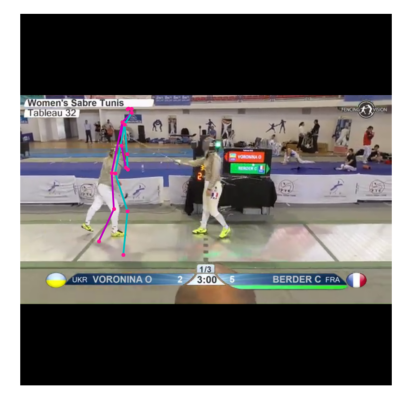

In [47]:
image_path = './test/test_img.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_png(image)

input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, 128, 256)
input_image = tf.cast(input_image, tf.int32)

# Run model inference.
keypoints_with_scores = movenet(input_image)['output_0'].numpy()

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')
